<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Handwritten Documents

## Imports
Dependencies needed to run the code, including mounting GoogleDrive and copying files.

In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Python
import gc
import os
import gzip
import tarfile
import time

# Data Structures
import pandas as pd
import numpy as np

# Debug/Progress
from tqdm import tqdm
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Image Manipulations / Plotting
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "drive/My Drive/datasets/iam-line-level.zip" "/content"
!cp "drive/My Drive/datasets/rimes-line-level.zip" "/content"
!unzip -q iam-line-level.zip -d iam
!unzip -q rimes-line-level.zip -d rimes
!rm iam-line-level.zip
!rm rimes-line-level.zip

### Create IAM and RIMES Dataset Classes

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(256,32)):
    self.desired_size = desired_size
    self.img_path = '/content/iam/images/'
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['img', 'transcription'])

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    # Resize here if needed
    x = transforms.functional.to_tensor(img)

    return x

  def __getitem__(self, index):
    path = 'iam/images/' + self.df['img'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

Transcription:  the tiller hard over and at the 



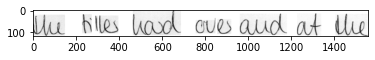

In [26]:
index = 10000
dataset = IamDataset()

print('Transcription: ', dataset[index][1], '\n')
plt.imshow(dataset[index][0].squeeze(), cmap='gray')

In [0]:
class RimesDataset(Dataset):
  def __init__(self, desired_size=(256,32)):
    self.desired_size = desired_size
    self.img_path = '/content/rimes/images/'
    self.df = pd.read_csv('/content/rimes/labels.csv', header=None, sep='\t', names=['img', 'transcription'])

  def get_df(self):
    return self.df

  def tensor_image(self, path):
    img = Image.open(path)
    # Resize here if needed
    x = transforms.functional.to_tensor(img)

    return x

  def __getitem__(self, index):
    path = 'rimes/images/' + self.df['img'][index]
    img = self.tensor_image(path)

    return img, self.df['transcription'][index]

Transcription:  Je vous adresse ce courrier afin 



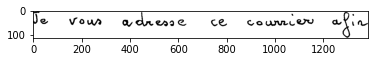

In [32]:
index = 0
dataset = RimesDataset()

print('Transcription: ', dataset[index][1], '\n')
plt.imshow(dataset[index][0].squeeze(), cmap='gray')

### Model

In [0]:
class Recognizer(nn.Module):
  def __init__(self, sequence_length=16):
    super(Recognizer, self).__init__()

    self.hidden_size = 256
    self.num_layers = 1

    # Encoder
    self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1), nn.Tanh())
    self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, 1, 1), nn.Tanh())
    self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.Tanh())
    self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.Tanh())
    self.conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.Tanh())

    self.gate1 = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1), nn.Sigmoid()) 
    self.gate2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.Sigmoid())
    self.gate3 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.Sigmoid())

    # Maxpool
    self.mp = nn.MaxPool2d((32, 1))

    # Decoder
    self.gru1 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size * 2, 128)
    self.gru2 = nn.GRU(128, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
    self.fc2 = nn.Linear(self.hidden_size * 2, sequence_length)
    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

  # Input -> (Batch, 1, 128, 256)
  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.conv2(out)

    gate1 = self.gate1(out)
    out = out * gate1

    out = self.conv3(out)

    gate2 = self.gate2(out)
    out = out * gate2

    out = self.conv4(out)

    gate3 = self.gate3(out)
    out = out * gate3

    out = self.conv5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = out.view(-1, 128, 128)

    out, _ = self.gru1(out)
    out = self.fc1(out)
    out, _ = self.gru2(out)
    out = self.fc2(out)
    out = self.softmax(out)

    # Change shape so that we can pass directly to CTC-Loss
    out = out.permute(2, 0, 1)

    return out